# Fashion MNIST Classification

In the other two notebooks in this series, we saw how we can use keras to classify two classes i.e. Horses and Humans from one another. In this notebook, we'll try to do a 10-class classification problem with the help of a basic CNN model using `Functional` model.

We have seen how to use `flow_from_directory` method in the `ImageDataGenerator` class in order to read images from directories on the fly and feed them to the neural networks to learn from the same. Here, I'll demonstrate how to use the `flow` method in order to feed data to a neural network from already defined images and labels in memory (i.e. not in directory but in this notebook only). Also, in this notebook, we'll use the alternative way of building a model in keras i.e. `Functional` and not the `Sequential` model which we've built in the other two notebooks in this repository.

In [1]:
import os

# For dataframe and matrix operations
import numpy as np
import pandas as pd

# For evaluation purposes
from sklearn.metrics import confusion_matrix

# For plotting purposes
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline

# The backend used by keras is tensorflow
import tensorflow as tf

# The layers needed to build a convolutional neural network
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D

# In order to build a CNN architecture with the functional framework
from keras.engine.input_layer import Input
from keras.models import Model

# In order to feed the images to CNN
from keras.preprocessing.image import ImageDataGenerator

# In order to specify the algorithm for backpropogation
from keras.optimizers import SGD

# In order to one-hot encode the output labels
from keras.utils import to_categorical

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
from keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [3]:
label_mapping = {0 : "T-shirt/top", 1 : "Trouser", 2 : "Pullover", 3 : "Dress", 4 : "Coat",
                5 : "Sandal", 6 : "Shirt", 7 : "Sneaker", 8 : "Bag", 9 : "Ankle boot"}

In [4]:
# Define some constants
image_width = 28
image_height = 28
num_channel = 1
batch_size = 10
num_epochs = 5

# Image Preparation

Let us view a few images from the train set and a few images from the test set and the train set.

In [5]:
def plot_images_from_set(set_name, label_name, n_img):
    fig, axes = plt.subplots(1, n_img, figsize = (12,12))
    for i in range(n_img):
        axes[i].axis('Off')
        axes[i].imshow(set_name[i], cmap = 'gray')
        axes[i].set_title(label_mapping[label_name[i]])

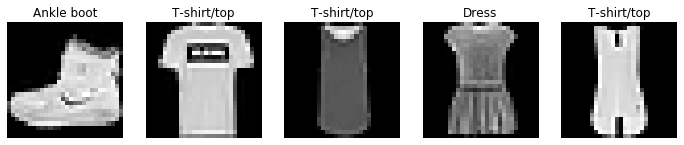

In [6]:
plot_images_from_set(x_train, y_train, 5)

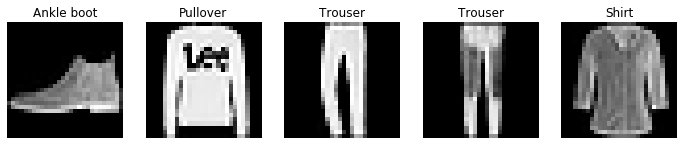

In [7]:
plot_images_from_set(x_test, y_test, 5)

In [8]:
print(f"Size of train dataset: {x_train.shape}\nSize of test dataset:  {x_test.shape}")

Size of train dataset: (60000, 28, 28)
Size of test dataset:  (10000, 28, 28)


Since we have a huge training dataset already, let's utilize this and train the model simply on this data and not include any augmented data in this set. 

Since our data is grayscale and since keras expects an image in 3-Dimensions, we need to reshape the x_train and x_test arrays accordingly.

Also, we need to one-hot encode our labels since they're 10 of them

In [9]:
# Resize the arrays so that we have a channel component in the grayscale image
X_tr = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
X_ts = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [10]:
# One hot encode the output labels
y_tr = to_categorical(y_train)
y_ts = to_categorical(y_test)

In [11]:
b_size = 32

# Create generator objects for train and validation data
IDG = ImageDataGenerator(validation_split = 0.2, rescale = 1/255.)
trainDataGen = IDG.flow(x = X_tr, y = y_tr, subset = 'training', batch_size = b_size)
valDataGen = IDG.flow(x = X_tr, y = y_tr, subset = 'validation', batch_size = b_size)

# Make a generator object for test data
testData = ImageDataGenerator(rescale = 1/255.).flow(x = X_ts, y = y_ts, batch_size = b_size)

# Model Architecture

First define all the connections in the below cell and then in the next cell, make a model that connects the first and the last layers together. 

In [12]:
# The first layer will be the input layer that contains 28 x 28 sized images
image_input = Input(shape=(image_width, image_height, num_channel), name = "Input_Layer")

# Next layer will be a Convolutional layer
conv1 = Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), 
               padding = 'valid', activation = 'relu', name = '1st_Conv')(image_input)
               
# Add another convolutional layer on top of the above layer.
conv2 = Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), 
               padding = 'valid', activation = 'relu', name = '2nd_Conv')(conv1)

# Add a MaxPooling Layer on top of the 2nd Convolutional layer
MP1 = MaxPool2D(pool_size = (2,2), name = "Max_Pooling_1")(conv2)

# Add a dropout layer for regularization (avoid overfitting)
DP = Dropout(rate = 0.5, name = "Dropout")(MP1)

# Flatten the input coming from the output of convolutional and subsampling layers.
Flat = Flatten(name = "Flatten")(DP)

# Add a Fully-connected layer to start the MLP for classification
FC1 = Dense(128, activation = 'relu', name = "Fully_Connected_1")(Flat)

# Add a dropout layer for regularization (avoid overfitting)
DP2 = Dropout(rate = 0.5, name = "Dropout2")(FC1)

# Add the output layer for classification
FC2 = Dense(10, activation = 'softmax', name = "Output_layer")(DP2)

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
model = Model(image_input, FC2)

In [14]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     (None, 28, 28, 1)         0         
_________________________________________________________________
1st_Conv (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
2nd_Conv (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
Max_Pooling_1 (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
Dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
Flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
Fully_Connected_1 (Dense)    (None, 128)               5899

In [15]:
model.compile(loss = 'categorical_crossentropy', optimizer = SGD(lr = 0.05), metrics = ['accuracy'])

# Model Fitting

**We will be using the fit_generator for training the neural network on train generator and validating on the validation generator object.**

Some of the parameters of the function fit_generator() are as follows. For a list of all parameters [visit here](https://keras.io/models/model/#fit_generator). 

- generator - It is the generator object defined on train data for which you've selected subset as training. It has 1500 batches each of size 32 i.e. 48000 samples. Remnant of the samples are in  validation generator

- epochs - Number of epochs for which to train the network

- verbose - 0,1,2 for none, all and some info about things happening in each epoch

- validation_data - It can be a tuple of x and y values or it can be a generator object as well which it is in this case. The validation set contains 60000 - 48000 = 12000 samples.

- validation_freq - It is the number of epochs after which validation should be carried out. We're defining it as 1 but in case there's a shortage of time/ computational resources are limited, we can decrease the frequency. ie let's say we need to validate after every 3 epochs, so, we can mention validation_freq = 3 and so on.

- shuffle - Whether elements in a batch also across batches will be shuffled.

In [16]:
model.fit_generator(generator = trainDataGen, epochs = num_epochs, verbose = 1, 
                   validation_data = valDataGen, validation_freq = 1, shuffle = True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
1500/1500 [==============================] - 132s 88ms/step - loss: 0.7130 - accuracy: 0.7379 - val_loss: 0.3270 - val_accuracy: 0.8453
Epoch 2/5
1500/1500 [==============================] - 134s 89ms/step - loss: 0.4775 - accuracy: 0.8255 - val_loss: 0.2960 - val_accuracy: 0.8749
Epoch 3/5
1500/1500 [==============================] - 126s 84ms/step - loss: 0.4209 - accuracy: 0.8475 - val_loss: 0.3702 - val_accuracy: 0.8828
Epoch 4/5
1500/1500 [==============================] - 133s 89ms/step - loss: 0.3865 - accuracy: 0.8589 - val_loss: 0.2093 - val_accuracy: 0.8898
Epoch 5/5
1500/1500 [==============================] - 135s 90ms/step - loss: 0.3617 - accuracy: 0.8685 - val_loss: 0.3549 - val_accuracy: 0.8935


# Model Predictions

Let us test how well our model performed on the never before seen test data

In [17]:
predictions = model.predict(X_ts)

In [18]:
y_pred_classes = np.argmax(predictions, axis = 1)

In [20]:
cm = confusion_matrix(y_test, y_pred_classes)
print(cm)

[[836   3   6  44  13   5  75   0  18   0]
 [  0 978   0  16   4   0   0   0   2   0]
 [ 10   3 596  11 279   1  86   0  14   0]
 [ 11  16   2 888  55   0  20   0   7   1]
 [  1   1   9  19 952   0  15   0   3   0]
 [  0   0   0   0   0 974   0  13   0  13]
 [154   2  48  37 222   1 507   0  29   0]
 [  0   0   0   0   0  38   0 878   0  84]
 [  0   2   0   5   3   3   1   3 982   1]
 [  0   0   0   0   0   7   0  16   1 976]]


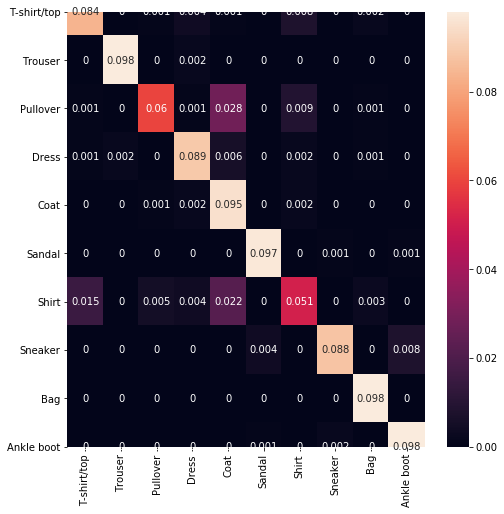

In [23]:
labels = label_mapping.values()
rcParams['figure.figsize'] = 8,8
data = pd.DataFrame(np.round(cm/ np.sum(cm), 3), index = labels, columns = labels)
sns.heatmap(data, annot = True)
plt.xticks(rotation = 90), plt.yticks(rotation = 0)
plt.show()

# Conclusion

We observe that since the **within class variance** is less and as the **across class variance** is more for this dataset, even a simple CNN with modest number of Convolution and Subsampling layers performs well.

Interestingly we can observe from the confusion matrix that the algorithm gets ambiguous for telling a shirt apart from a coat or a t-shirt. This happens because they are similar figures or their across class variance is low.

The accuracy of this model can be further increased by using Data Augmentation (Image Augmentation) thereby training the data on more and more samples. Increasing the number of epochs will also help in that improving in that direction. 

In this notebook we understood:
- Building a NN Model in keras using Functional API.
- Using flow method of ImageDataGenerator class to fit the model in batches of required size.
- Visualize the output using a Confusion Matrix and interpret the result in terms of class variances.